In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Start with just importing the time domain module of simpeg, and a utility to plot a layered model.
import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
    inversion,
)

from simpeg.data_misfit import L2DataMisfit

import discretize
from discretize import TensorMesh

# Load data from .csv

In [10]:
file_path = "/Users/shekholam/Desktop/UBC/EOSC_556/Project/Data/AusAEM-WA/AusAEM_WA_Block_E_EM.csv"
df = pd.read_csv(file_path, 
                 #delim_whitespace=True,
                 delimiter=",") 
                 #sep=r'\s+', 
                 #comment='#') #delimiter="\t")#, comment='#')  # Ignore headers if marked with '#'

/var/folders/nv/3rmg65wj733gdy4gk5sxm8cc0000gn/T/ipykernel_1591/1942277806.py:2: DtypeWarning: Columns (153,154,156,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,


In [11]:
# take a look of the dataframe/
df.head()

,GA_Project,Job_No,Fiducial,Line,Flight,DateTime,Date_UTC,Time_UTC,What,Date_Local,...,RUNC_HM_Z_19,RUNC_HM_Z_20,RUNC_HM_Z_21,RUNC_HM_Z_22,RUNC_HM_Z_23,MA1,BMAG,TMI,IGRF,TMI_IGRF
0,100101,5002,10079,43500879,100101,20210827.01,44435.00509,20210827,719.5,20210827.1,...,3.95584,6.45271,4.14097,37.22344,2.98606,57747.00,58335.57,57744.43,57898.01,58179.42
1,100101,5002,10079,43500880,100101,20210827.01,44435.00509,20210827,720.0,20210827.0,...,4.37806,7.87759,4.43024,25.36838,2.89718,57748.45,58335.57,57745.88,57898.02,58180.87
2,100101,5002,10079,43500881,100101,20210827.01,44435.00510,20210827,720.5,20210827.0,...,4.73999,8.92172,4.52947,16.99572,2.85546,57749.54,58335.57,57746.96,57898.02,58181.94
3,100101,5002,10079,43500882,100101,20210827.01,44435.00510,20210827,721.0,20210827.0,...,5.14875,9.81910,4.50944,11.99612,2.85190,57749.98,58335.58,57747.40,57898.02,58182.38
4,100101,5002,10079,43500883,100101,20210827.01,44435.00511,20210827,721.5,20210827.0,...,5.47572,10.91546,4.44444,9.06249,2.87407,57749.75,58335.58,57747.16,57898.01,58182.15


In [12]:
# Replace invalid values (-99999999) with NaN
df.replace(-99999999, np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
# Drop rows with missing values
df.dropna(inplace=True)

In [20]:
#filter data of flight lines 101102 and 101201
df_101102 = df[df["GA_Project"] == 101102]
df_101201 = df[df["GA_Project"] == 101201]

df_101201.shape

(8841, 193)

In [14]:
# extract lat, lon, easting, northing, Z-comp LM dB/dt processed and normalised, Z-comp HM dB/dt processed and normalised, 
# Z-comp LM dB/dt relative uncertainty, Z-comp HM dB/dt relative uncerttainty

# lat, lon (WGS84)
lat=df_101102["Latitude"]
lon=df_101102["Longitude"]

# easting, northing (GDA2020 MGA Zone 50)
easting=df_101102["Easting"]
northing=df_101102["Northing"]

# z component Low Moment, High Moment 
LM_Z=df_101102.iloc[:, 65:83]*1e-12
HM_Z=df_101102.iloc[:, 83:106]*1e-12

# z component relative uncertainty Low Moment, High Moment
RUNC_LM_Z=df_101102.iloc[:, 106:124]
RUNC_HM_Z=df_101102.iloc[:, 124:147]


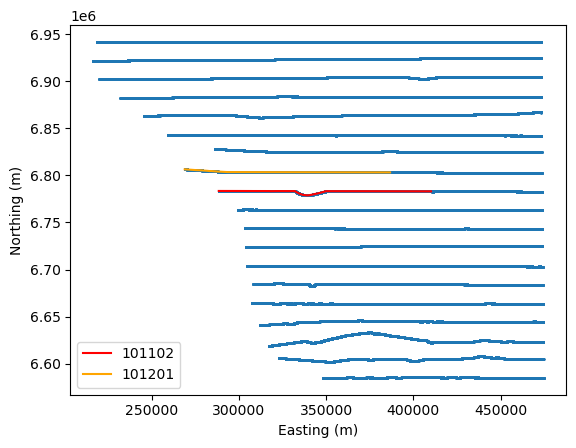

In [10]:
# plot all flight lines and selected flight lines

plt.scatter(df["Easting"], df["Northing"], s=0.5)
plt.plot(easting, northing, label="101102", c="r")
plt.plot(df_101201["Easting"], df_101201["Northing"], label="101201", c="orange")
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.legend()
plt.show()

In [12]:
# Normalize LM_Z and HM_Z by dividing by their peak values
# Provided data are normalized. 

# LM_Z_norm = LM_Z / LM_Z.max()
# HM_Z_norm = HM_Z / HM_Z.max()

# Starting with single station (sounding)

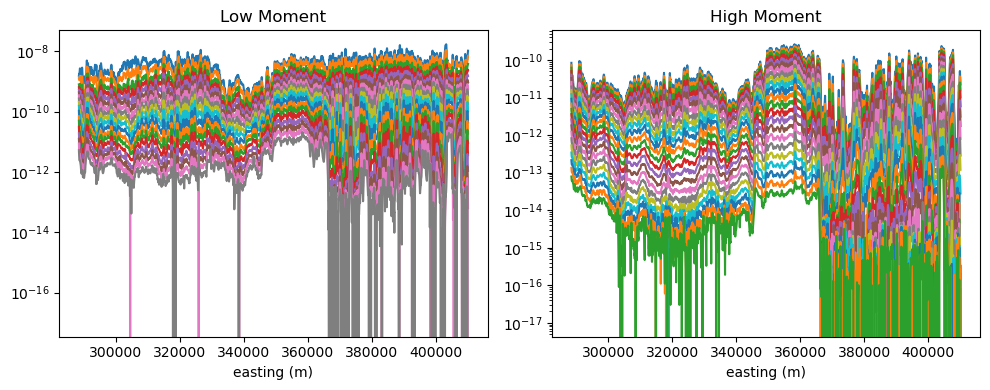

In [14]:
# look at the data
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].semilogy(easting, LM_Z)
ax[0].set_xlabel('easting (m)')
#ax[0].set_ylim(1e-5, 1e5)
ax[0].set_title('Low Moment')

ax[1].semilogy(easting, HM_Z)
ax[1].set_xlabel('easting (m)')
ax[1].set_title('High Moment')

plt.tight_layout()

In [29]:
LM_Z

,LM_Z_1,LM_Z_2,LM_Z_3,LM_Z_4,LM_Z_5,LM_Z_6,LM_Z_7,LM_Z_8,LM_Z_9,LM_Z_10,LM_Z_11,LM_Z_12,LM_Z_13,LM_Z_14,LM_Z_15,LM_Z_16,LM_Z_17,LM_Z_18
119680,1.046573e-08,7.034521e-09,3.803359e-09,2.334478e-09,1.505166e-09,9.200169e-10,5.709254e-10,3.395638e-10,1.766721e-10,1.025365e-10,4.406167e-11,1.880210e-11,9.104240e-12,3.649510e-12,1.078630e-12,6.314000e-14,-2.618200e-13,-1.738700e-13
119681,9.917287e-09,6.767200e-09,3.716929e-09,2.299949e-09,1.490548e-09,9.242460e-10,5.925221e-10,3.645859e-10,1.927281e-10,1.176811e-10,5.342926e-11,2.408159e-11,1.148209e-11,4.990290e-12,1.499230e-12,2.904300e-13,-1.163400e-13,-1.436000e-13
119682,9.467839e-09,6.662222e-09,3.758053e-09,2.354849e-09,1.523722e-09,9.405291e-10,6.018737e-10,3.700748e-10,1.955424e-10,1.219505e-10,5.659996e-11,2.625698e-11,1.276501e-11,5.686130e-12,1.748370e-12,4.274100e-13,-4.500000e-14,-1.506600e-13
119683,8.960448e-09,6.509090e-09,3.781529e-09,2.418261e-09,1.571108e-09,9.712033e-10,6.187654e-10,3.792187e-10,2.003879e-10,1.260668e-10,5.953509e-11,2.822210e-11,1.409277e-11,6.404290e-12,2.033230e-12,5.713700e-13,2.749000e-14,-1.391500e-13
119684,8.420030e-09,6.268390e-09,3.738827e-09,2.458352e-09,1.618921e-09,1.014989e-09,6.461453e-10,3.959750e-10,2.102188e-10,1.313298e-10,6.281207e-11,3.009095e-11,1.541946e-11,7.137820e-12,2.345840e-12,7.189700e-13,9.972000e-14,-1.137600e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127096,1.628015e-09,1.131518e-09,6.951810e-10,5.376507e-10,4.193939e-10,3.230865e-10,2.419586e-10,1.840795e-10,1.347055e-10,9.774731e-11,6.667204e-11,4.360277e-11,3.055120e-11,1.959129e-11,1.278821e-11,8.899630e-12,5.971850e-12,3.716610e-12
127097,1.613088e-09,1.159160e-09,7.204252e-10,5.595671e-10,4.423222e-10,3.450697e-10,2.611589e-10,2.000624e-10,1.481355e-10,1.080981e-10,7.340423e-11,4.820645e-11,3.386384e-11,2.175282e-11,1.403050e-11,9.619170e-12,6.478800e-12,4.058650e-12
127098,1.598716e-09,1.192449e-09,7.471944e-10,5.857847e-10,4.688624e-10,3.716758e-10,2.851195e-10,2.201812e-10,1.650529e-10,1.212183e-10,8.199114e-11,5.403201e-11,3.813620e-11,2.442285e-11,1.549508e-11,1.044302e-11,7.086890e-12,4.439950e-12
127099,1.578774e-09,1.229484e-09,7.744109e-10,6.148851e-10,4.984447e-10,4.027550e-10,3.143056e-10,2.451615e-10,1.858515e-10,1.374486e-10,9.309501e-11,6.148061e-11,4.356498e-11,2.772758e-11,1.721038e-11,1.144160e-11,7.861080e-12,4.856200e-12


In [29]:
# Select a single sounding along that line, and grab all of the data associated with that station
# Record 5999
station = df_101102[1999:2000]
station_lm_data = station.iloc[0, 65:83].to_numpy()*1e-12
#station_lm_std = station.iloc[0, 9+n_lm_gates:9+2*n_lm_gates].to_numpy()
station_hm_data = station.iloc[0, 83:106].to_numpy()*1e-12
#station_hm_std = station.iloc[0,  9+2*n_lm_gates + n_hm_gates:].to_numpy()

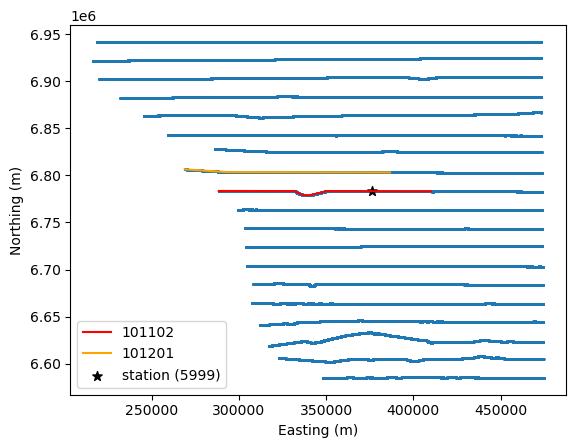

In [31]:
# show selected station
plt.scatter(df["Easting"], df["Northing"], s=0.5)
plt.plot(easting, northing, label="101102", c="r")
plt.plot(df_101201["Easting"], df_101201["Northing"], label="101201", c="orange")
plt.scatter(station["Easting"], station["Northing"], c="k", marker="*", label="station (5999)", s=50)
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.legend()
plt.show()

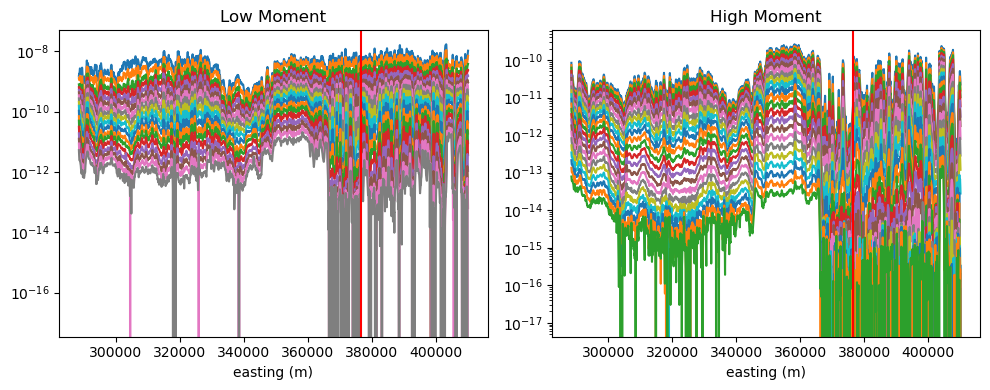

In [32]:
# look at the data
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].semilogy(easting, LM_Z)
ax[0].set_xlabel('easting (m)')
ax[0].axvline(station.iloc[0, 17], c="r")
#ax[0].set_ylim(1e-5, 1e5)
ax[0].set_title('Low Moment')

ax[1].semilogy(easting, HM_Z)
ax[1].set_xlabel('easting (m)')
ax[1].axvline(station.iloc[0, 17], c="r")
ax[1].set_title('High Moment')

plt.tight_layout()

In [34]:
# load the gate opening time for LM and HM respectively
LM_excel = "../Data/LM_times.csv"
HM_excel = "../Data/HM_times.csv"
LM_times_csv = pd.read_csv(LM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_times_csv = pd.read_csv(HM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [35]:
# extract gate_centre (s)
LM_times = LM_times_csv["Gate Centre (s)"].to_numpy()
HM_times = HM_times_csv["Gate Centre (s)"].to_numpy()

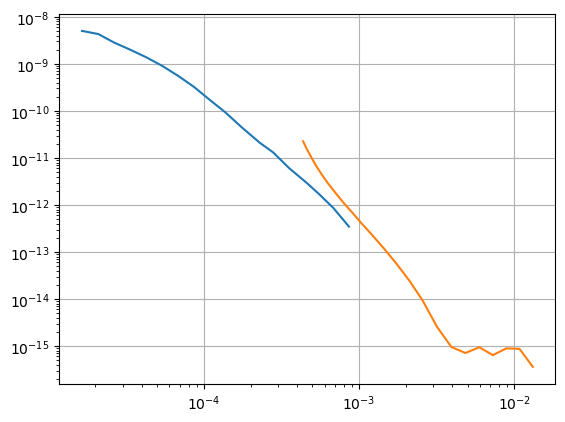

In [37]:
# plot data for single station (1999)
plt.loglog(LM_times, station_lm_data)
plt.loglog(HM_times, station_hm_data)
plt.grid()

# Setting up survey

In [42]:
LM_waveform_excel = "../Data/LM_waveform.csv"
HM_waveform_excel = "../Data/HM_waveform.csv"
LM_waveform_csv = pd.read_csv(LM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_waveform_csv = pd.read_csv(HM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [44]:
# extract the time and form from waveform_csv 
LM_wave_time = LM_waveform_csv["Time (s)"]
LM_wave_form = LM_waveform_csv["Amplitude"]
HM_wave_time = HM_waveform_csv["Time (s)"]
HM_wave_form = HM_waveform_csv["Amplitude"]

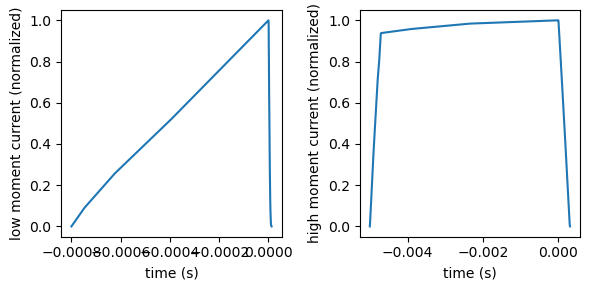

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].plot(LM_wave_time, LM_wave_form)
ax[0].set_ylabel("low moment current (normalized)")
ax[0].set_xlabel("time (s)")

ax[1].plot(HM_wave_time, HM_wave_form)
ax[1].set_ylabel("high moment current (normalized)")
ax[1].set_xlabel("time (s)")

plt.tight_layout()

In [48]:
# shape of the transmitter, and the offset of the receiver coil.
tx_shape = np.array([[-12.64,  -2.13,   0.  ],
       [ -6.15,  -8.59,   0.  ],
       [  5.74,  -8.59,   0.  ],
       [ 11.13,  -3.19,   0.  ],
       [ 11.13,   3.19,   0.  ],
       [  5.74,   8.59,   0.  ],
       [ -6.15,   8.59,   0.  ],
       [-12.64,   2.13,   0.  ],
       [-12.64,  -2.13,   0.  ]])
rx_offset = np.array([-13.46,   0.  ,  -2.  ]) # from data processing report

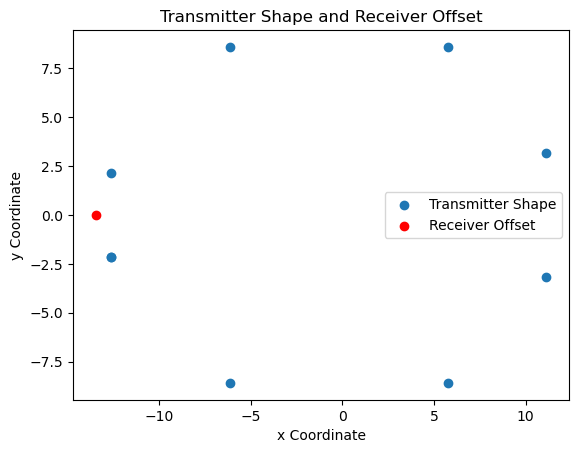

In [50]:
# Extract x and y coordinates for transmitter shape
tx_x = [point[0] for point in tx_shape]
tx_y = [point[1] for point in tx_shape]

# Scatter plot for transmitter shape
plt.scatter(tx_x, tx_y, label='Transmitter Shape')

# Scatter plot for receiver offset
plt.scatter(rx_offset[0], rx_offset[1], label='Receiver Offset', color='red')

# Add labels and legend
plt.xlabel('x Coordinate')
plt.ylabel('y Coordinate')
plt.title('Transmitter Shape and Receiver Offset')
plt.legend()

# Show the plot
plt.show()

In [51]:
# add UTM coordinates to transmitter shape and the receiver offset
# tx_loc = tx_shape + [311527.56, 6783344.30, station["GPS_Alt"].iloc[0]]
tx_loc = tx_shape + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["GPS_Alt"].iloc[0]] # 17 is easting, 18 is northing, 19 is altitude of Tx loop
rx_loc = rx_offset + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["GPS_Alt"].iloc[0]]
tx_area=342.0 # from data processing report

In [54]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, LM_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(LM_wave_time, LM_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

In [56]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, HM_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(HM_wave_time, HM_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

In [58]:
srv = tdem.Survey([src_lm, src_hm])
srv_lm = tdem.Survey(src_lm)
srv_hm = tdem.Survey(src_hm)

In [90]:
# simple forward simulation
thicknesses = [1]
conductivities = [1e-3,1e-2]

In [92]:
sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

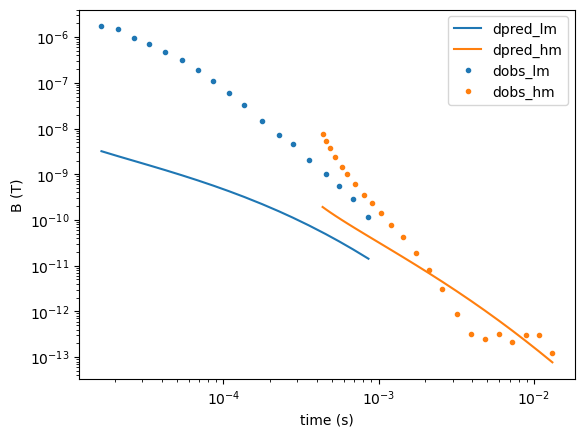

In [94]:
# sim.thicknesses = [5]
# sim.sigma = [3E-1]
pre = -sim.dpred(None)
pre_lm = pre[:18]
pre_hm = pre[18:]

plt.loglog(LM_times, pre_lm, label="dpred_lm")
plt.loglog(HM_times, pre_hm, label="dpred_hm")
plt.loglog(LM_times, station_lm_data*tx_area, color='C0', marker='.', linestyle='', label="dobs_lm")
plt.loglog(HM_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='', label="dobs_hm")
plt.xlabel("time (s)")
plt.ylabel("B (T)")
plt.legend()
plt.show()

# Set up inversion for single station

In [96]:
# map
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

In [98]:
# noise std? = uncertainties
station_lm_std = station.iloc[0, 147: 165].to_numpy()
station_hm_std = station.iloc[0, 165: 188].to_numpy()

In [100]:
# observed data (normalised) & relative errors 
dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
rel_err = np.r_[station_lm_std, station_hm_std]

# Convert 'dobs' to a proper numeric array
dobs = np.array(dobs, dtype=np.float64)  # Force float64 conversion

# Ensure no NaN or infinite values
dobs = np.nan_to_num(dobs, nan=1e-10, posinf=1e-10, neginf=-1e-10)

# Convert 'rel_err' to a proper numeric array
rel_err = np.array(rel_err, dtype=np.float64)  # Ensure float64 type

# Handle NaN or invalid values
rel_err = np.nan_to_num(rel_err, nan=1e-10, posinf=1e-10, neginf=1e-10)

# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

# data_container = data.Data(srv, dobs=dobs, relative_error=uncertainties) # method 2 to obtain data_object
data_container = data.Data(srv, dobs=dobs, relative_error=rel_err) # method 1 to obtain data_object


In [102]:
data_container[src_hm, rx_hm]

array([-7.72755156e-09, -5.44562838e-09, -3.79421298e-09, -2.35256328e-09,
       -1.47286062e-09, -9.92299320e-10, -6.15268260e-10, -3.58303140e-10,
       -2.32881480e-10, -1.40880060e-10, -7.94397600e-11, -4.15085400e-11,
       -1.93264200e-11, -8.20116000e-12, -3.13272000e-12, -8.72100000e-13,
       -3.24900000e-13, -2.42820000e-13, -3.21480000e-13, -2.18880000e-13,
       -3.04380000e-13, -2.97540000e-13, -1.23120000e-13])

In [104]:
sim_inv1 = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)

In [106]:
phi_d_1 = L2DataMisfit(data=data_container, simulation=sim_inv1)

In [119]:
# we can evaluate this function.
m_0 = np.log(1E-2)  # sigma = 1E-2 S/m

phi_d_1(m_0)

20543101.68460447

In [120]:
minimizer = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)
# Here, Inexact means we are going to use CG to solve for the step direction.

In [121]:
empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
# note we needed to pass a mesh that had a single cell
# in it because our model has 1 value.

In [125]:
inv_prob_1 = inverse_problem.BaseInvProblem(
    phi_d_1, reg=empty_reg, opt=minimizer, beta=0.0
)

# sets up, phi_d + 0 * phi_m, meaning the minimizer is only going to act on the data misfit term.

In [127]:
inv1 = inversion.BaseInversion(inv_prob_1, [])

In [129]:
# Run inversion
recovered_model = inv1.run(m_0)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.05e+07  0.00e+00  2.05e+07    9.64e+04      0              
   1  0.00e+00  2.05e+07  5.00e+00  2.05e+07    7.63e+04      3              
   2  0.00e+00  2.05e+07  1.00e+00  2.05e+07    1.88e+04      6              
   3  0.00e+00  2.05e+07  1.97e+00  2.05e+07    1.76e+04      4              
   4  0.00e+00  2.05e+07  1.13e+00  2.05e+07    1.31e+04      5              
   5  0

In [130]:
# What was our recovered best fitting halfspace?
sim_inv1.sigmaMap * recovered_model

array([0.03341443])

In [131]:
# This function returns a data object
# (so we can easily index it with receivers for plotting)
data_pre = sim_inv1.make_synthetic_data(recovered_model)

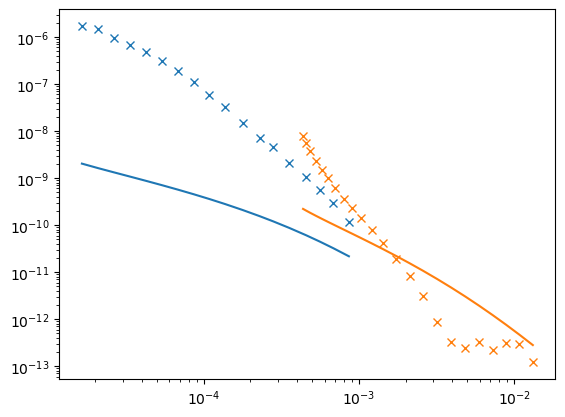

In [132]:
def plot_data(data_obj):
    plt.loglog(LM_times, -data_obj[src_lm, rx_lm])
    plt.loglog(HM_times, -data_obj[src_hm, rx_hm])
    
    plt.loglog(
        LM_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
    )
    plt.loglog(
        HM_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
    )
    
plot_data(data_pre)

### Multiple layers

In [138]:
n_layers = 5
wire_map = maps.Wires(('sigma',n_layers), ('thicknesses', n_layers-1))

In [140]:
sigma_map = exp_map * wire_map.sigma
thick_map = exp_map * wire_map.thicknesses

In [142]:
# let's use the best fitting half-space as our initial model
m_sigma_0_2 = np.full(n_layers, recovered_model[0])  # Already in log-space
m_h_0_2 = np.log(np.full(n_layers-1, 10))
m_0_2 = np.r_[m_sigma_0_2, m_h_0_2]

sim_inv2 = tdem.Simulation1DLayered(srv, sigmaMap=sigma_map, thicknessesMap=thick_map)

In [144]:
sim_inv2.model = m_0_2
sim_inv2.sigma

array([0.03341443, 0.03341443, 0.03341443, 0.03341443, 0.03341443])

In [146]:
phi_d_2 = L2DataMisfit(data=data_container, simulation=sim_inv2)

# create all of the same components of the inversion problem as before
minimizer2 = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# again create a reg that has the same input size as the model vector, and then turn it off by setting `beta=0`
empty_reg = regularization.Smallness(discretize.TensorMesh([len(m_0_2)]))
inv_prob_2 = inverse_problem.BaseInvProblem(
    phi_d_2, reg=empty_reg, opt=minimizer, beta=0.0
)

In [148]:
inv2 = inversion.BaseInversion(inv_prob_2, [])

# Run inversion
recovered_model_2 = inv2.run(m_0_2)

The callback on the InexactGaussNewton Optimization was replaced.

Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.05e+07  0.00e+00  2.05e+07    8.83e+04      0              


/Applications/anaconda3/envs/simpeg-env/lib/python3.9/site-packages/simpeg/maps/_property_maps.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(mkvc(m))


   1  0.00e+00  2.04e+07  1.03e+00  2.04e+07    9.63e+04     11              
   2  0.00e+00  2.04e+07  1.46e+00  2.04e+07    1.04e+05     13   Skip BFGS  
   3  0.00e+00  2.04e+07  1.84e+00  2.04e+07    1.06e+05     15   Skip BFGS  
   4  0.00e+00  2.04e+07  2.22e+00  2.04e+07    1.07e+05     16   Skip BFGS  
   5  0.00e+00  2.04e+07  2.52e+00  2.04e+07    1.08e+05     17   Skip BFGS  
   6  0.00e+00  2.04e+07  2.95e+00  2.04e+07    1.08e+05     17   Skip BFGS  
   7  0.00e+00  2.04e+07  3.61e+00  2.04e+07    1.09e+05     17   Skip BFGS  
   8  0.00e+00  2.04e+07  4.08e+02  2.04e+07    4.26e+05     11   Skip BFGS  
   9  0.00e+00  2.02e+07  1.22e+03  2.02e+07    1.90e+05      4              
  10  0.00e+00  2.02e+07  4.13e+02  2.02e+07    1.68e+05      3              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 6.5054e+03 <= tolF*(1+|f0|) = 2.0480e+06
0 : |xc-x_last| = 7.7258e+01 <= tolX*(1+|x0|) = 9.8863e-01
0 : |proj(x-g)-x|    = 1.6776e+05 <= tolG     

In [151]:
data_pre_2 = sim_inv2.make_synthetic_data(recovered_model_2)
sim_inv2.sigma, sim_inv2.thicknesses

(array([2.12330695e+16, 6.74146141e-06, 2.34252777e-05, 1.48711810e+04,
        4.97855508e-02]),
 array([9.80599103e-17, 9.01529185e+03, 4.09707479e+00, 3.41647542e-05]))

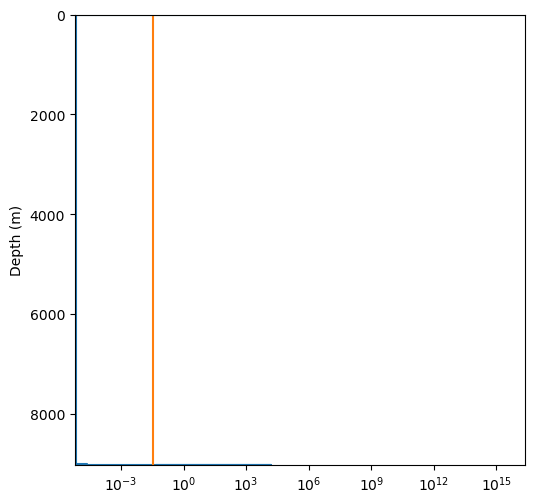

In [153]:
ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax.axvline(sim_inv1.sigma, color='C1')
#ax.set_ylim([50, 0])
#ax.set_xlim([1E-2, 1E0]);

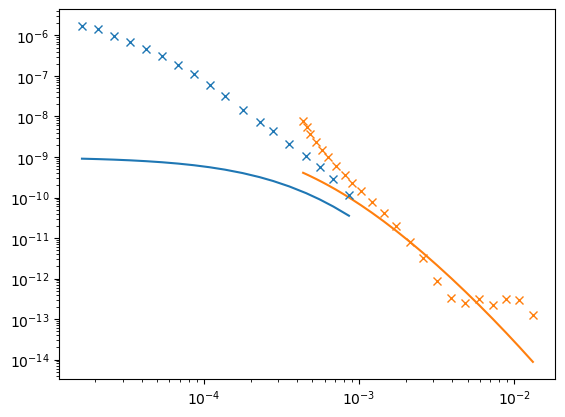

In [155]:
plot_data(data_pre_2)

### Regularized inversion

In [159]:
# (start_size, number_of_cells, expansion_factor)
h = [1, (1.0, 63, 1.05)]
mesh = discretize.TensorMesh([h,])
mesh

TensorMesh: 64 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64          0.00        434.09      1.00     21.62    1.05

In [161]:
sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])

phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)

# This class creates a function that measures the smallness
# and the smoothness of the model.
reg = regularization.WeightedLeastSquares(mesh)

In [163]:
m_0_reg = np.full(mesh.n_cells, recovered_model[0])

In [165]:
# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

inv_prob_3 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg, beta=5
)

In [167]:
inv3 = inversion.BaseInversion(inv_prob_3, [])

# Run inversion
recovered_model_3 = inv3.run(m_0_reg)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+00  2.05e+07  0.00e+00  2.05e+07    2.42e+04      0              
   1  5.00e+00  2.04e+07  3.98e+01  2.04e+07    2.71e+04      6              
   2  5.00e+00  2.03e+07  8.85e+01  2.03e+07    2.02e+04      6              
   3  5.00e+00  2.03e+07  2.71e+0

(0.001, 1.0)

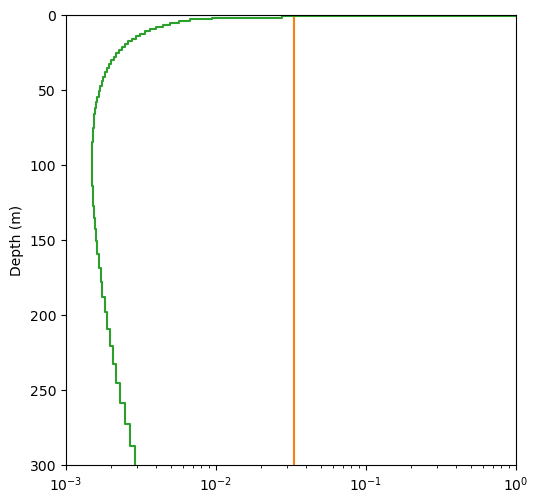

In [168]:
data_pre_3 = sim_reg.make_synthetic_data(recovered_model_3)
ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax.axvline(sim_inv1.sigma, color='C1')
plot_1d_layer_model(sim_reg.thicknesses, sim_reg.sigma, ax=ax, color='C2')
ax.set_ylim([300, 0])
ax.set_xlim([1E-3, 1E0])

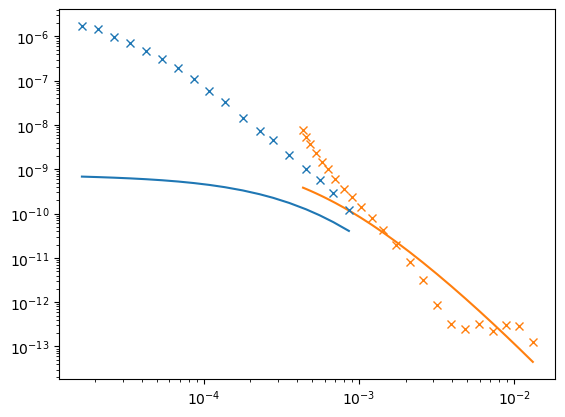

In [169]:
plot_data(data_pre_3)

In [438]:
beta_cooler = directives.BetaSchedule(coolingFactor=5, coolingRate=2)

In [440]:
save_dict = directives.SaveOutputDictEveryIteration()

In [442]:
# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=100, tolCG=1e-5
)

inv_prob_4 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg, beta=10000
)

inv4 = inversion.BaseInversion(inv_prob_4, [save_dict, beta_cooler])

# Run inversion
recovered_model_4 = inv4.run(m_0_reg)


Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+04  2.81e+07  0.00e+00  2.81e+07    6.42e+05      0              
   1  1.00e+04  2.62e+07  2.00e+01  2.64e+07    4.15e+05      2              
   2  2.00e+03  2.53e+07  3.74e+01  2.54e+07    3.73e+05      2              
   3  2.00e+03  2.46e+07  7.53e+01  2.48e+07    9.51e+05      3              
   4  4.00e+02  2.43e+07  1.02e+02  2.43e+07    9.00e+05      3              
   5  4.00e+02  2.40e+07  4.01e+02  2.41e+07    2.53e+06      3         

In [444]:
n_iter = save_dict.opt.iter
phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
betas =  [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]

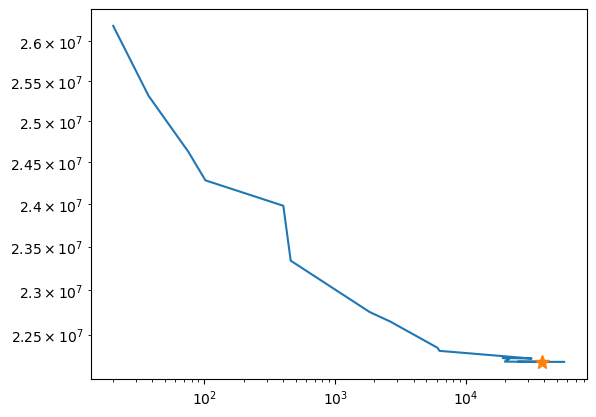

In [446]:

# this is an L-curvey plot
plt.loglog(phi_ms, phi_ds)
plt.loglog(phi_ms[14], phi_ds[14], marker='*', markersize=10)

(0.001, 1.0)

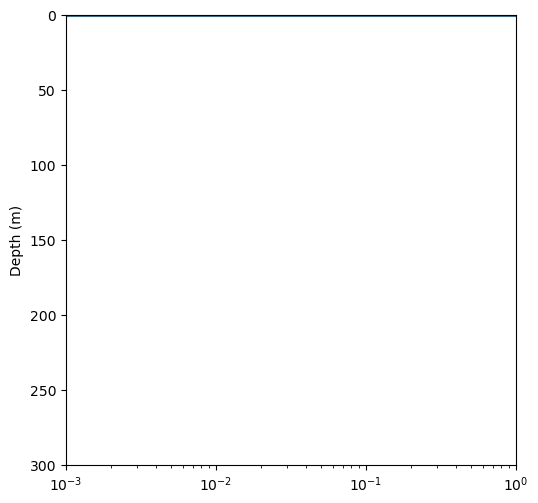

In [452]:
m_final = save_dict.outDict[14]['m']
d_final = sim_reg.make_synthetic_data(m_final)
ax = plot_1d_layer_model(sim_reg.thicknesses, exp_map * m_final)
plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma, ax=ax)
ax.set_ylim([300, 0])
ax.set_xlim([1E-3, 1E0])

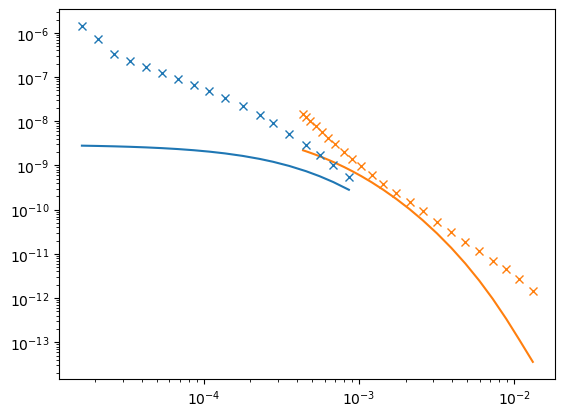

In [454]:
plot_data(d_final)